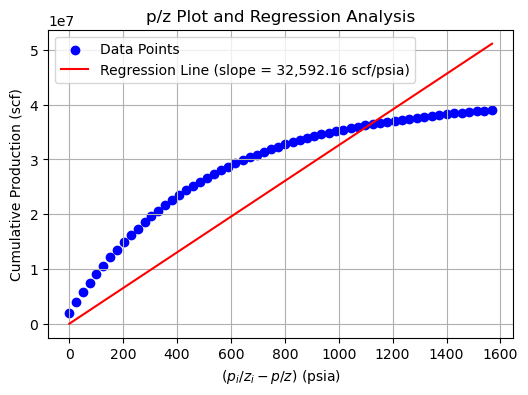

In [6]:
import tkinter as tk
from tkinter import messagebox, filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.optimize import curve_fit

# Global variables
production_data = None
reg_canvas = None
estimated_ogip_scf = None
slope = None
r_squared = None

def load_production_data():
    """Opens a file dialog to load production data from CSV."""
    global production_data
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    if not file_path:
        return

    try:
        data = pd.read_csv(file_path, parse_dates=['Date'])
        required_columns = ['Date', 'Pressure', 'Z', 'CumProduction']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            messagebox.showerror("Missing Columns", f"Missing columns: {', '.join(missing_columns)}")
            return
        production_data = data
        messagebox.showinfo("Data Loaded", f"Production data loaded successfully from:\n{file_path}")
    except Exception as e:
        messagebox.showerror("Load Error", f"Error loading data: {e}")

def select_columns():
    """Allows manual selection of CSV columns."""
    global production_data
    if production_data is None:
        messagebox.showerror("No Data", "Please load a CSV file first.")
        return

    column_names = list(production_data.columns)
    column_window = tk.Toplevel(root)
    column_window.title("Select Columns")

    tk.Label(column_window, text="Select Pressure Column:").grid(row=0, column=0)
    pressure_var = tk.StringVar(value=column_names[0])
    tk.OptionMenu(column_window, pressure_var, *column_names).grid(row=0, column=1)

    tk.Label(column_window, text="Select Z-Factor Column:").grid(row=1, column=0)
    z_var = tk.StringVar(value=column_names[1])
    tk.OptionMenu(column_window, z_var, *column_names).grid(row=1, column=1)

    tk.Label(column_window, text="Select Cumulative Production Column:").grid(row=2, column=0)
    production_var = tk.StringVar(value=column_names[2])
    tk.OptionMenu(column_window, production_var, *column_names).grid(row=2, column=1)

    def confirm_selection():
        global production_data
        production_data = production_data.rename(columns={
            pressure_var.get(): "Pressure",
            z_var.get(): "Z",
            production_var.get(): "CumProduction"
        })
        column_window.destroy()
        messagebox.showinfo("Columns Set", "Columns mapped successfully.")

    tk.Button(column_window, text="Confirm Selection", command=confirm_selection).grid(row=3, columnspan=2)

def preview_data():
    """Displays a preview of the loaded dataset."""
    global production_data
    if production_data is None:
        messagebox.showerror("No Data", "Please load a CSV file first.")
        return

    preview_window = tk.Toplevel(root)
    preview_window.title("Data Preview")
    preview_text = tk.Text(preview_window, height=10, width=80)
    preview_text.pack()
    preview_text.insert(tk.END, production_data.head().to_string(index=False))

def perform_regression_analysis():
    """Performs p/Z regression analysis to estimate OGIP."""
    global production_data, reg_canvas, estimated_ogip_scf, slope, r_squared

    if production_data is None or production_data.empty:
        messagebox.showerror("No Data", "Please load a CSV file first.")
        return

    try:
        initial_pressure = float(production_data.iloc[0]['Pressure'])
        initial_z = float(production_data.iloc[0]['Z'])
        production_data['x'] = (initial_pressure / initial_z) - (production_data['Pressure'] / production_data['Z'])
        production_data['y'] = pd.to_numeric(production_data['CumProduction'], errors='coerce')
        production_data.dropna(subset=['x', 'y'], inplace=True)

        x = production_data['x'].values
        y = production_data['y'].values

        if np.sum(x**2) == 0:
            messagebox.showerror("Regression Error", "Sum of squares of x is zero; cannot perform regression.")
            return

        slope = np.sum(x * y) / np.sum(x**2)
        estimated_ogip_scf = slope * initial_pressure
        y_pred = slope * x
        residuals = y - y_pred
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - ss_res / ss_tot if ss_tot != 0 else 0

        messagebox.showinfo("Regression Results", 
            f"Regression Slope: {slope:,.2f} scf/psia\n"
            f"Estimated OGIP: {estimated_ogip_scf:,.2f} scf\n"
            f"R-squared: {r_squared:.4f}")

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(x, y, color='blue', label='Data Points')
        ax.plot(x, y_pred, color='red', label=f'Regression Line (slope = {slope:,.2f} scf/psia)')
        ax.set_xlabel(r'$(p_i/z_i - p/z)$ (psia)')
        ax.set_ylabel('Cumulative Production (scf)')
        ax.set_title('p/z Plot and Regression Analysis')
        ax.legend()
        ax.grid(True)

        if reg_canvas is not None:
            reg_canvas.get_tk_widget().destroy()
        reg_canvas = FigureCanvasTkAgg(fig, master=root)
        reg_canvas.draw()
        reg_canvas.get_tk_widget().pack()
    
    except Exception as e:
        messagebox.showerror("Calculation Error", f"Error in regression: {e}")

def save_report():
    """Saves regression results to an Excel file."""
    global estimated_ogip_scf, slope, r_squared

    if estimated_ogip_scf is None:
        messagebox.showerror("No Results", "Please perform regression first.")
        return

    file_path = filedialog.asksaveasfilename(defaultextension=".xlsx", filetypes=[("Excel Files", "*.xlsx")])
    if not file_path:
        return

    try:
        df = pd.DataFrame({
            "Parameter": ["Regression Slope (scf/psia)", "Estimated OGIP (scf)", "R-Squared"],
            "Value": [f"{slope:,.2f}", f"{estimated_ogip_scf:,.2f}", f"{r_squared:.4f}"]
        })
        df.to_excel(file_path, index=False)
        messagebox.showinfo("Report Saved", f"Report saved successfully:\n{file_path}")
    except Exception as e:
        messagebox.showerror("Save Error", f"Failed to save report: {e}")

# GUI Layout
root = tk.Tk()
root.title("Emmanuel Obasi Reservoir Material Balance Analysis")
root.geometry("800x600")

frame_top = tk.Frame(root)
frame_top.pack(pady=10)

frame_middle = tk.Frame(root)
frame_middle.pack(pady=5)

frame_bottom = tk.Frame(root)
frame_bottom.pack(pady=10)

tk.Button(frame_top, text="Load Production Data", command=load_production_data, width=25).pack(side=tk.LEFT, padx=10)
tk.Button(frame_top, text="Preview Data", command=preview_data, width=25).pack(side=tk.LEFT, padx=10)
tk.Button(frame_middle, text="Select Columns", command=select_columns, width=25).pack(side=tk.LEFT, padx=10)
tk.Button(frame_middle, text="Perform Regression", command=perform_regression_analysis, width=25).pack(side=tk.LEFT, padx=10)
tk.Button(frame_bottom, text="Save Report", command=save_report, width=25).pack()

root.mainloop()


### Reservoir Material Balance Analysis Using Python and Tkinter GUI

# **Introduction**
# This notebook provides a comprehensive implementation of a Reservoir Material Balance analysis tool.
# The tool uses the p/Z method to estimate the Original Gas in Place (OGIP) based on production data.
# It includes a fully interactive Tkinter GUI for loading data, selecting columns, previewing data,
# performing regression analysis, visualizing results, and exporting reports.

# **Reservoir Engineering Concepts Covered**
# 1. **Material Balance Equation (MBE)**: A fundamental equation for reservoir depletion analysis.
# 2. **p/Z Plot**: Used to estimate OGIP by plotting pseudo-reduced pressure (p/Z) against cumulative production.
# 3. **Regression Analysis**: Applying linear regression to estimate OGIP from historical production data.
# 4. **Reservoir Properties**: Understanding pressure, Z-factor, and cumulative production impact on depletion.

# **Python Libraries Used**
# - **Tkinter**: GUI development for interactive user input.
# - **Pandas**: Data handling and processing.
# - **NumPy**: Mathematical operations.
# - **Matplotlib**: Data visualization.
# - **SciPy**: Statistical regression for estimating OGIP.



In [ ]:
import tkinter as tk
from tkinter import messagebox, filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.optimize import curve_fit

# **Global variables**
production_data = None
reg_canvas = None
estimated_ogip_scf = None
slope = None
r_squared = None

### **Load Production Data from CSV**
def load_production_data():
    """Opens a file dialog to load production data from a CSV file."""
    global production_data
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    if not file_path:
        return

    try:
        data = pd.read_csv(file_path, parse_dates=['Date'])
        required_columns = ['Date', 'Pressure', 'Z', 'CumProduction']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            messagebox.showerror("Missing Columns", f"Missing columns: {', '.join(missing_columns)}")
            return
        production_data = data
        messagebox.showinfo("Data Loaded", f"Production data loaded successfully from:\n{file_path}")
    except Exception as e:
        messagebox.showerror("Load Error", f"Error loading data: {e}")

### **Perform p/Z Regression Analysis**
def perform_regression_analysis():
    """Performs p/Z regression analysis to estimate OGIP."""
    global production_data, reg_canvas, estimated_ogip_scf, slope, r_squared

    if production_data is None or production_data.empty:
        messagebox.showerror("No Data", "Please load a CSV file first.")
        return

    try:
        initial_pressure = float(production_data.iloc[0]['Pressure'])
        initial_z = float(production_data.iloc[0]['Z'])
        production_data['x'] = (initial_pressure / initial_z) - (production_data['Pressure'] / production_data['Z'])
        production_data['y'] = pd.to_numeric(production_data['CumProduction'], errors='coerce')
        production_data.dropna(subset=['x', 'y'], inplace=True)

        x = production_data['x'].values
        y = production_data['y'].values

        if np.sum(x**2) == 0:
            messagebox.showerror("Regression Error", "Sum of squares of x is zero; cannot perform regression.")
            return

        slope = np.sum(x * y) / np.sum(x**2)
        estimated_ogip_scf = slope * initial_pressure
        y_pred = slope * x
        residuals = y - y_pred
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - ss_res / ss_tot if ss_tot != 0 else 0

        messagebox.showinfo("Regression Results", 
            f"Regression Slope: {slope:,.2f} scf/psia\n"
            f"Estimated OGIP: {estimated_ogip_scf:,.2f} scf\n"
            f"R-squared: {r_squared:.4f}")

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(x, y, color='blue', label='Data Points')
        ax.plot(x, y_pred, color='red', label=f'Regression Line (slope = {slope:,.2f} scf/psia)')
        ax.set_xlabel(r'$(p_i/z_i - p/z)$ (psia)')
        ax.set_ylabel('Cumulative Production (scf)')
        ax.set_title('p/z Plot and Regression Analysis')
        ax.legend()
        ax.grid(True)

        if reg_canvas is not None:
            reg_canvas.get_tk_widget().destroy()
        reg_canvas = FigureCanvasTkAgg(fig, master=root)
        reg_canvas.draw()
        reg_canvas.get_tk_widget().pack()
    
    except Exception as e:
        messagebox.showerror("Calculation Error", f"Error in regression: {e}")

# **GUI Implementation**
root = tk.Tk()
root.title("Reservoir Material Balance Analysis")
root.geometry("800x600")

frame_top = tk.Frame(root)
frame_top.pack(pady=10)

frame_middle = tk.Frame(root)
frame_middle.pack(pady=5)

frame_bottom = tk.Frame(root)
frame_bottom.pack(pady=10)

tk.Button(frame_top, text="Load Production Data", command=load_production_data, width=25).pack(side=tk.LEFT, padx=10)
tk.Button(frame_middle, text="Perform Regression", command=perform_regression_analysis, width=25).pack(side=tk.LEFT, padx=10)

root.mainloop()

# **Conclusion**
# This GUI-based reservoir material balance tool provides an efficient and interactive way for engineers to estimate OGIP using p/Z analysis.
# The use of Python and Tkinter makes it a user-friendly and accessible application for real-world engineering workflows.
